# Zestaw 5

### Kamil Burkiewicz

#### Imports

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from queue import LifoQueue as queue
from PIL import Image
from functools import reduce
from time import time

###  Pattern match and example trie tree visualization

In [2]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, leaf_vs_root_factor = 0.5):

    '''
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    Based on Joel's answer at https://stackoverflow.com/a/29597209/2966723,
    but with some modifications.  

    We include this because it may be useful for plotting transmission trees,
    and there is currently no networkx equivalent (though it may be coming soon).
    
    <...>  
    
    :Arguments: 
    
    **G** the graph (must be a tree)

    **root** the root node of the tree 
    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be 
      just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    **width** horizontal space allocated for this branch - avoids overlap with other branches

    **vert_gap** gap between levels of hierarchy

    **vert_loc** vertical location of root
    
    **leaf_vs_root_factor**

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, leftmost, width, leafdx = 0.2, vert_gap = 0.2, vert_loc = 0, 
                    xcenter = 0.5, rootpos = None, 
                    leafpos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if rootpos is None:
            rootpos = {root:(xcenter,vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = list(G.neighbors(root))
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            rootdx = width/len(children)
            nextx = xcenter - width/2 - rootdx/2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(G,child, leftmost+leaf_count*leafdx, 
                                    width=rootdx, leafdx=leafdx,
                                    vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, 
                                    xcenter=nextx, rootpos=rootpos, leafpos=leafpos, parent = root)
                leaf_count += newleaves

            leftmostchild = min((x for x,y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x,y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild+rightmostchild)/2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root]  = (leftmost, vert_loc)
            
        return rootpos, leafpos, leaf_count

    xcenter = width/2.
    if isinstance(G, nx.DiGraph):
        leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==0])
    elif isinstance(G, nx.Graph):
        leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==1 and node != root])
    
    if leafcount == 0:
        return None
    rootpos, leafpos, leaf_count = _hierarchy_pos(G, root, 0, width, 
                                                    leafdx=width*1./leafcount, 
                                                    vert_gap=vert_gap, 
                                                    vert_loc = vert_loc, 
                                                    xcenter = xcenter)
    pos = {}
    for node in rootpos:
        pos[node] = (leaf_vs_root_factor*leafpos[node][0] + (1-leaf_vs_root_factor)*rootpos[node][0], leafpos[node][1]) 
    xmax = max(x for x,y in pos.values())
    for node in pos:
        pos[node]= (pos[node][0]*width/xmax, pos[node][1])
    return pos

In [3]:
# separator chosen so that the helper part of labels is hidden
separator = "\n" + " " * 440

def flatten_tree(trie):
    q = queue()
    q.put(trie.root)
    nodes = []
    
    while (not q.empty()):
        node = q.get()
        nodes += [node]
        for child in sorted(node.children()):
            q.put(child)
            
    return nodes
            
def node_repr(v, i):
    return "\n" + str(v) + separator + str(i)

def visualize(trie, node_repr=node_repr, size=[6.4, 4.8], title=None):
    G = nx.DiGraph()
    nodes = flatten_tree(trie)
    nrs = {}
    
    # Add all nodes
    for i, v in enumerate(nodes):
        G.add_node(node_repr(v, i))
        nrs[v] = i
    
    # Add all edges
    for i, v in enumerate(nodes):
        for child in sorted(v.children()):
            G.add_edge(node_repr(v, i), node_repr(child, nrs[child]))
    
    H = G.copy()
    link_edge_list = []
    for i, v in enumerate(nodes):
        if (v.fail_link):
            link_edge_list += [(node_repr(v, i), node_repr(v.fail_link, nrs[v.fail_link]))]
            H.add_edge(*link_edge_list[-1])

    plt.figure(3, figsize=size)
    plt.title(title)
    pos = hierarchy_pos(G, node_repr(trie.root, 0))
    nx.draw(G, pos=pos, with_labels=True, color=[0.0, 0.8, 1.0])
    nx.draw_networkx_edges(H, pos=pos, edgelist=link_edge_list, edge_color='red')
    plt.show()

In [4]:
def make_pattern_surrounding(pixels, start, pattern_shape, image_shape, color=(255, 0, 0)):
    height, width = image_shape
    x, y = start
    x -= 1
    y -= 1
    for i in range(pattern_shape[0] + 2):
        if (0 <= x + i < height and 0 <= y < width):
            pixels[x + i, y] = color
        if (0 <= x + i < height and 0 <= y + pattern_shape[1] + 1 < width):
            pixels[x + i, y + pattern_shape[1] + 1] = color
        if (0 <= x + i < height and 0 <= y - 1 < width):
            pixels[x + i, y - 1] = color
        if (0 <= x + i < height and 0 <= y + pattern_shape[1] + 2 < width):
            pixels[x + i, y + pattern_shape[1] + 2] = color
            
    for i in range(pattern_shape[1] + 2):
        if (0 <= x < height and 0 <= y + i < width):
            pixels[x, y + i] = color
        if (0 <= x + pattern_shape[0] + 1 < height and 0 <= y + i < width):
            pixels[x + pattern_shape[0] + 1, y + i] = color
        if (0 <= x - 1 < height and 0 <= y + i < width):
            pixels[x - 1, y + i] = color
        if (0 <= x + pattern_shape[0] + 2 < height and 0 <= y + i < width):
            pixels[x + pattern_shape[0] + 2, y + i] = color

def highlight_found(image, pattern, occurences):
    img_copy = image.copy()
    pixels = img_copy.load()
    for occurence in occurences:
        x, y = occurence
        make_pattern_surrounding(pixels, (y, x), pattern.size, img_copy.size)
    return img_copy

## Time measurement functions

In [107]:
def timeit(method):
    """ 
    Decorator for measuring time.
    It shows arguments of function.
    """
    
    def timed(*args, **kw):
        num_of_meas = 5
        time_measurements = []
        
        for _ in range(num_of_meas):
            ts = time()
            result = None
            result = method(*args, **kw)
            te = time()
            time_measurements += [(te - ts) * 1000]
            
        mean = sum(time_measurements) / len(time_measurements)
        std = np.sqrt(sum(np.power(np.array(time_measurements) - mean, 2) / (len(time_measurements))))
        print("%s%23s \t %10.3f ms +/- %.2f ms" % (method.__name__, ("()").ljust(23), mean, std))
        return result
    return timed

@timeit
def build_trie_time(pattern):
    return AhoCorasickTrie(pattern)

@timeit
def search_time(trie, text):
    return trie.search(text)

@timeit
def naive_matching_time(pattern, text):
    occurences = naive_matching(pattern, text)
    return occurences

def measure_time(text, patterns):
    for pattern in patterns:
        trie = build_trie_time(pattern)
        occurences_trie = search_time(trie, text)
        occurences_naive = naive_matching_time(pattern, text)
        occurences_trie = sorted(sorted(occurences_trie, key=lambda x: x[1]), key=lambda x: x[0])
        occurences_naive = sorted(sorted(occurences_naive, key=lambda x: x[1]), key=lambda x: x[0])
        print(f"Results are the same: {np.all(occurences_trie == occurences_naive)}")

@timeit
def measure_time_multiple_text(texts, pattern):
    trie = AhoCorasickTrie(pattern)
    occurences = []
    for text in texts:
        occurences += trie.search(text_array)
    
    return occurences

## Actual code

In [105]:
class TrieNode:
    def __init__(self, letter='', parent=None):
        self.letter = letter
        self.parent = None
        self.fail_link = None
        self.leaf = False
        self.state = 0
        self._children = {}
        
    def __getitem__(self, key):
        return self._children[key]
    
    def __setitem__(self, key, item):
        self._children[key] = item
    
    def __delitem__(self, key):
        del self._children[key]
    
    def __len__(self):
        return len(self._children)
    
    def __repr__(self):
        return str(self.letter)
    
    def __contains__(self, item):
        return item in self._children
    
    def children(self):
        return self._children.values()

    def __lt__(self, other):
        return self.letter < other.letter
    

class AhoCorasickTrie:
    def __init__(self, pattern):
        self.root = TrieNode()
        self.pattern = pattern
        self.words_nrs = []         # Final states for every column word in pattern.
        words = pattern.transpose() # numpy.array with rows being patterns.
        
        # Enumerate states from 1 up, final states accepting pattern columns are nonzero.
        state = 1
        
        # Trie building.
        for i, word in enumerate(words):
            node = self.root
            i = 0
            while (i < len(word)):
                if (word[i] in node):
                    node = node[word[i]]
                else:
                    new_node = TrieNode(word[i], parent=node)
                    node[word[i]] = new_node
                    node = new_node
                i += 1
            if (not node.leaf):
                node.leaf = True
                node.state = state
                state += 1
            self.words_nrs += [node.state]
        
        # Fail linking process.
        
        # Initial fail links for children of root.
        self.root.fail_link = self.root
        for child in self.root.children():
            child.fail_link = self.root
        
        # Fail links for all trie.
        for node in self._bfs_order():
            for child in node.children():
                while (child.fail_link is None):
                    child.fail_link = self._find_fail_link(child.letter, node)
                

    def _find_fail_link(self, letter, node):
        while (node.fail_link and node.fail_link is not node):
            node = node.fail_link
            if (letter in node):
                return node[letter]
        return self.root
    
    def _bfs_order(self):
        """ Generator of all nodes in level ordering.
        """
        Q = queue()
        Q.put(self.root)
        
        while (not Q.empty()):
            node = Q.get()
            yield node
            for child in node.children():
                Q.put(child)
                
    def search(self, text):
        """ Search a pattern in a text.
        """
        new_text = np.full((text.shape[0] + 1, text.shape[1]), -1)
        new_text[:-1,] = text
        text = new_text
        textT = text.transpose()
        states = np.zeros(textT.shape)
        result = []
        node = self.root
        
        for i, column in enumerate(textT):
            for j, letter in enumerate(column):
                while letter not in node and node is not self.root:
                    node = node.fail_link
                if (letter in node):
                    node = node[letter]
                if (node.leaf):
                    states[i, j] = node.state
           
        states_rows = states.transpose()[:-1,:]
        pattern_height, pattern_width = self.pattern.shape
        occurences = []
        for i, row in enumerate(states_rows):
            for j in range(len(row) - pattern_width + 1):
                if (reduce(lambda x, y: x and y, row[j:j+pattern_width] == self.words_nrs)):
                    occurences += [(i - pattern_height + 1, j)]
        return occurences

In [7]:
def find_character_in_two_lines(text, omit_characters):
    occurences = []
    for i in range(text.shape[0] - 1):
        for j in range(text.shape[1]):
            if (text[i, j] not in omit_characters and text[i, j] == text[i + 1, j]):
                occurences += [(i, j)]
    return occurences

In [8]:
def naive_matching(pattern, text):
    occurences = []
    p_height = pattern.shape[0]
    p_width = pattern.shape[1]
    for i in range(text.shape[0] - p_height + 1):
        for j in range(text.shape[1] - p_width + 1):
            if (np.all(text[i:i + p_height, j:j + p_width] == pattern)):
                occurences += [(i, j)]
    return occurences

In [9]:
def convert_image_to_nparray(image, base=256):
    """ Convert image to 2d np.array of integers based on rgb of each pixel.
    """
    rgb_array = np.array(image)
    return rgb_array[:,:,0] + base * rgb_array[:,:,1] + base**2 * rgb_array[:,:,2]

# Tests

## Simple trial with prechosen data

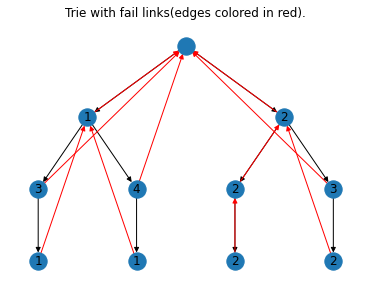

Pattern occuernces: [(0, 2), (3, 1)]


In [109]:
p = np.array([[1, 2, 1, 2],
              [3, 3, 4, 2],
              [1, 2 ,1, 2]
             ])
t = np.array([[1, 1, 1, 2, 1, 2],   #  [ 1,  1, |1,  1,  1,  2|]  occurence in (0, 2)
              [3, 4, 3, 3, 4, 2],   #  [ 3,  4, |3,  3,  4,  2|]
              [1, 4, 1, 2, 1, 2],   #  [ 2,  4, |1,  2,  1,  2|]
              [3, 1, 2, 1, 2, 3],   #  [ 3, |1,  2,  1,  2,| 3 ]  occurence in (3, 1)
              [1, 3, 3, 4, 2, 2],   #  [ 1, |3,  3,  4,  2,| 2 ]
              [2, 1, 2, 1, 2, 1]    #  [ 2, |1,  2,  2,  2,| 1 ]
             ])

trie = AhoCorasickTrie(p)
# this visualization may fail for big tries, due to a simplification
visualize(trie, title="Trie with fail links(edges colored in red).")
print(f"Pattern occuernces: {trie.search(t)}")

## Find all occurences of the same letters in the same position in two consecutive lines

In [110]:
# Open haystack.txt and allign all lines to the same length

try:
    with open("Resources/haystack.txt", "rb") as f:
        haystack_text = np.array(f.readlines())
except Exception as e:
    print(e)

max_len = max(map(len, haystack_text))
haystack_array = np.full((haystack_text.shape[0], max_len), -1)
for i, row in enumerate(haystack_text):
    haystack_array[i, :len(row)] = [x for x in row]

In [111]:
print("All occurences of the same letters in the same position in two consecutive lines:")
print(find_character_in_two_lines(haystack_array, omit_characters=[-1]))

All occurences of the same letters in the same position in two consecutive lines:
[(2, 183), (4, 0), (6, 98), (9, 0), (11, 148), (13, 47), (13, 211), (14, 56), (17, 216), (19, 0), (21, 43), (21, 47), (21, 137), (25, 0), (27, 28), (27, 121), (27, 141), (28, 182), (28, 282), (29, 97), (30, 0), (35, 329), (35, 484), (36, 209), (39, 3), (39, 51), (39, 191), (39, 496), (39, 497), (39, 498), (40, 21), (40, 52), (40, 325), (40, 422), (44, 4), (44, 147), (45, 251), (45, 283), (48, 4), (51, 164), (53, 16), (54, 65), (56, 100), (60, 77), (61, 91), (64, 15), (64, 93), (64, 127), (68, 193), (68, 232), (68, 570), (68, 643), (68, 795), (68, 796), (69, 271), (69, 362), (70, 477), (71, 105), (71, 243), (71, 621), (74, 115), (76, 38), (77, 15), (79, 84), (83, 0), (86, 192), (86, 277), (86, 328), (86, 386), (86, 473), (86, 603), (86, 679), (86, 683), (86, 709), (86, 794), (89, 0), (91, 5), (91, 366), (92, 294), (92, 306), (92, 390), (92, 678), (92, 735), (94, 0), (94, 1), (94, 312), (95, 61), (99, 282),

## Find all occurences of 'th' and 't h' in two consecutive lines of png image

In [112]:
try:
    text_image = Image.open("Resources/haystack.png")
    t_h = Image.open("Resources/t h.png")
except Exception as e:
    print(e)
    
t_h_array = convert_image_to_nparray(t_h)
text_array = convert_image_to_nparray(text_image)

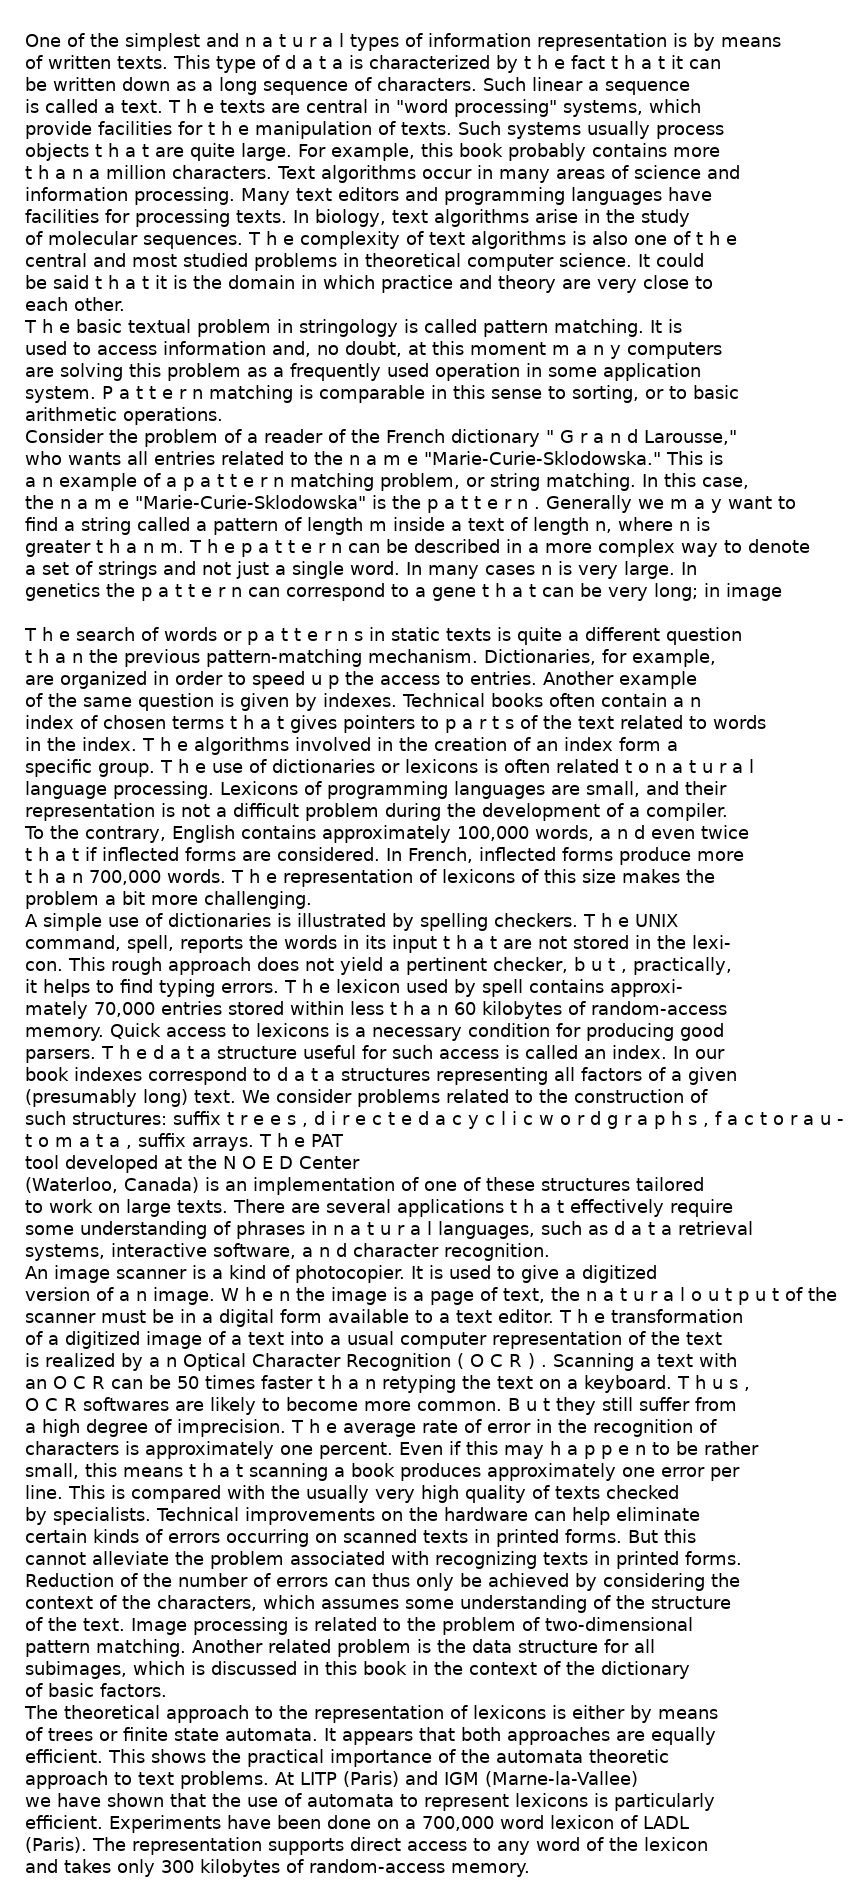

In [113]:
text_image

In [114]:
t_h

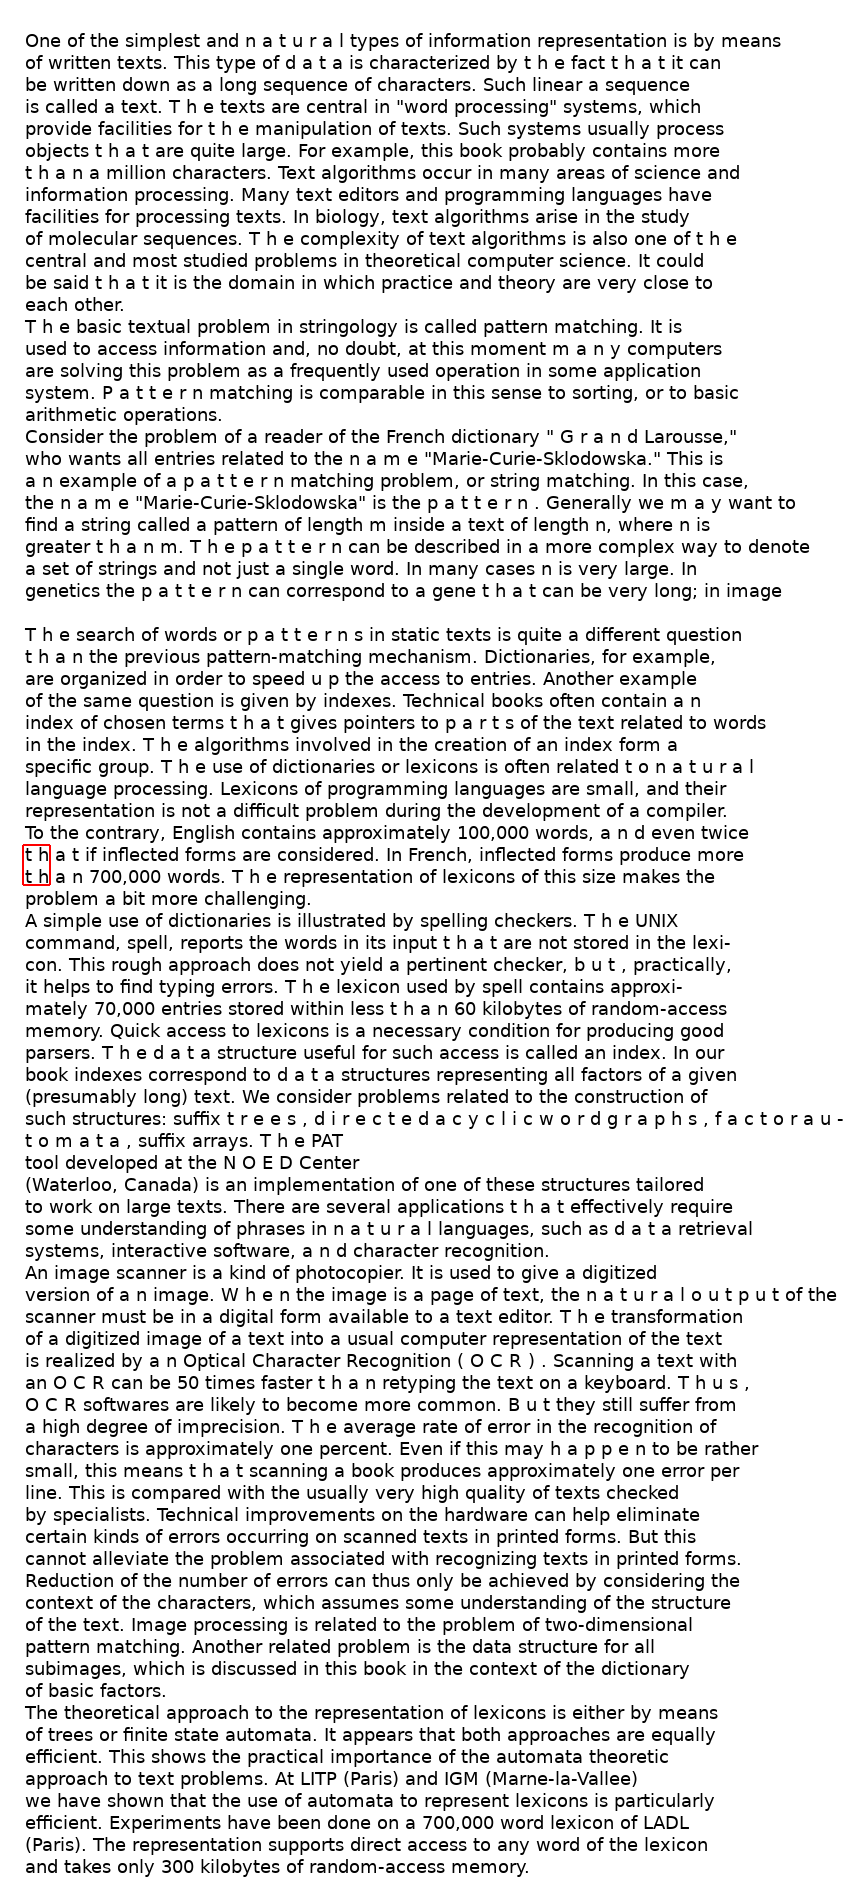

In [115]:
trie = AhoCorasickTrie(t_h_array)
occurences = trie.search(text_array)
highlight_found(text_image, t_h, occurences)

In [116]:
try:
    th = Image.open("Resources/th.png")
except Exception as e:
    print(e)
    
th_array = convert_image_to_nparray(th)

In [117]:
th

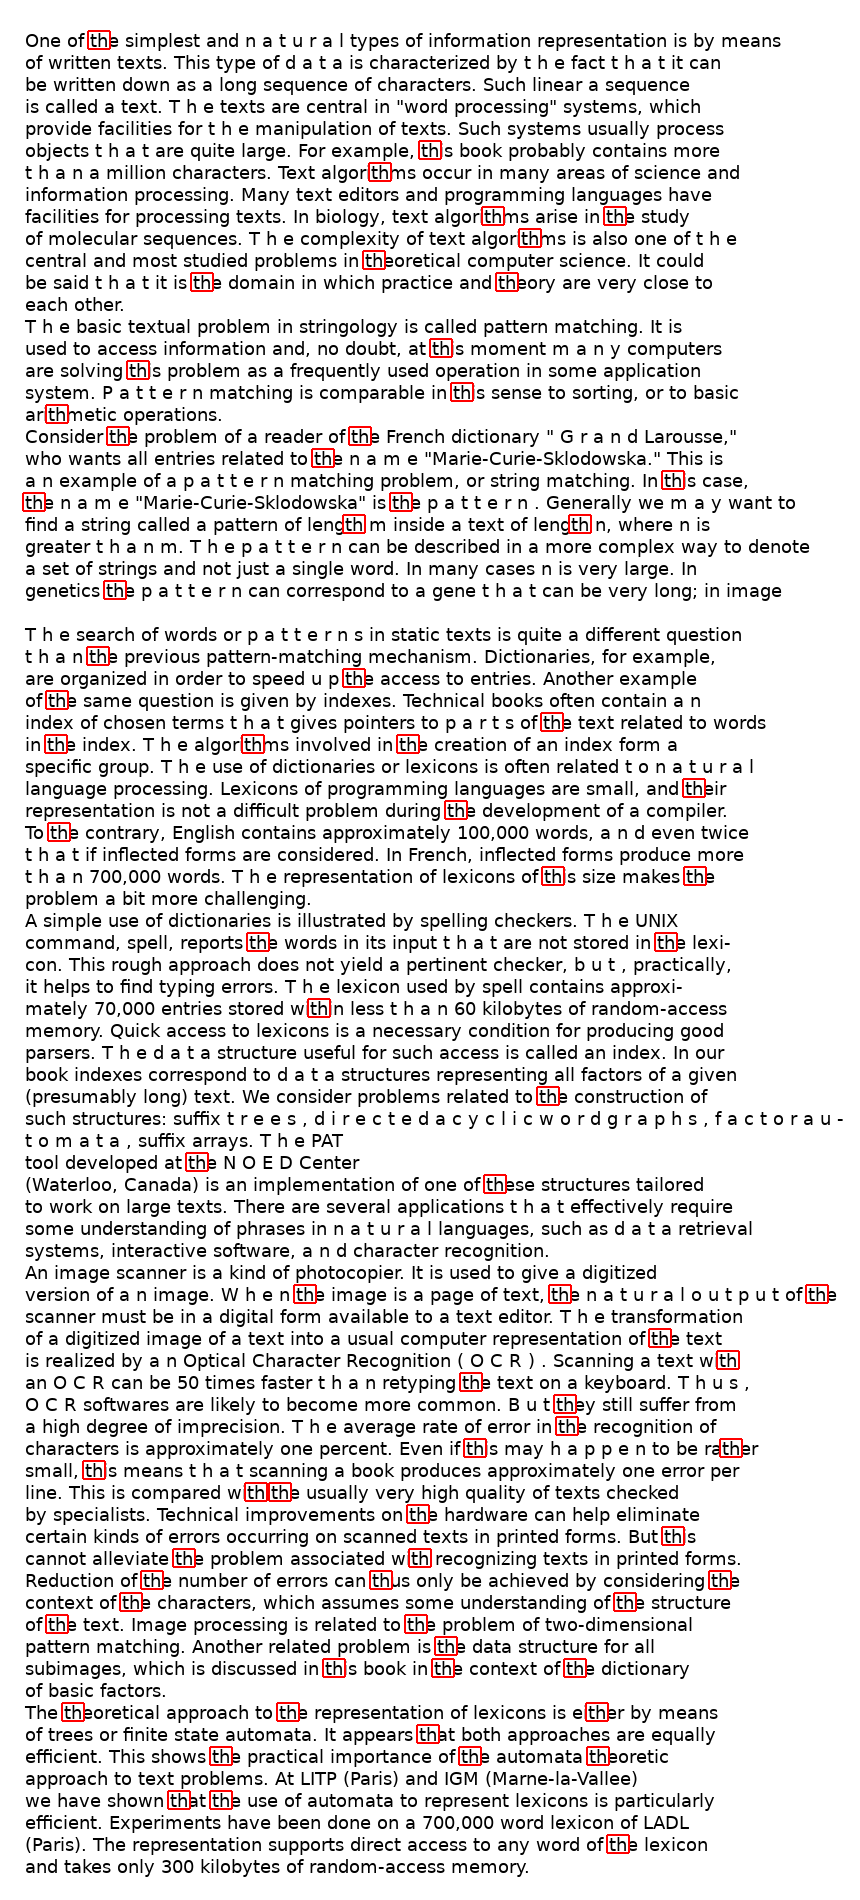

In [118]:
trie = AhoCorasickTrie(th_array)
occurences = trie.search(text_array)
highlight_found(text_image, th, occurences)

<b>Note: Two occurences of 'th' are not present in this file, one exactly below the other. The only sensible candidates are all imperfectcly fit with each other and that makes the algorithm not applicable here.</b>

## Find all occurences of at least four choosen lower case letters in png

Chosen characters are - a, e, i, t.

In [119]:
try:
    a_img = Image.open("Resources/a.png")
    e_img = Image.open("Resources/e.png")
    i_img = Image.open("Resources/i.png")
    t_img = Image.open("Resources/t.png")
except Exception as e:
    print(e)
    
a_array = convert_image_to_nparray(a_img)
e_array = convert_image_to_nparray(e_img)
i_array = convert_image_to_nparray(i_img)
t_array = convert_image_to_nparray(t_img)
a_trie = AhoCorasickTrie(a_array)
e_trie = AhoCorasickTrie(e_array)
i_trie = AhoCorasickTrie(i_array)
t_trie = AhoCorasickTrie(t_array)

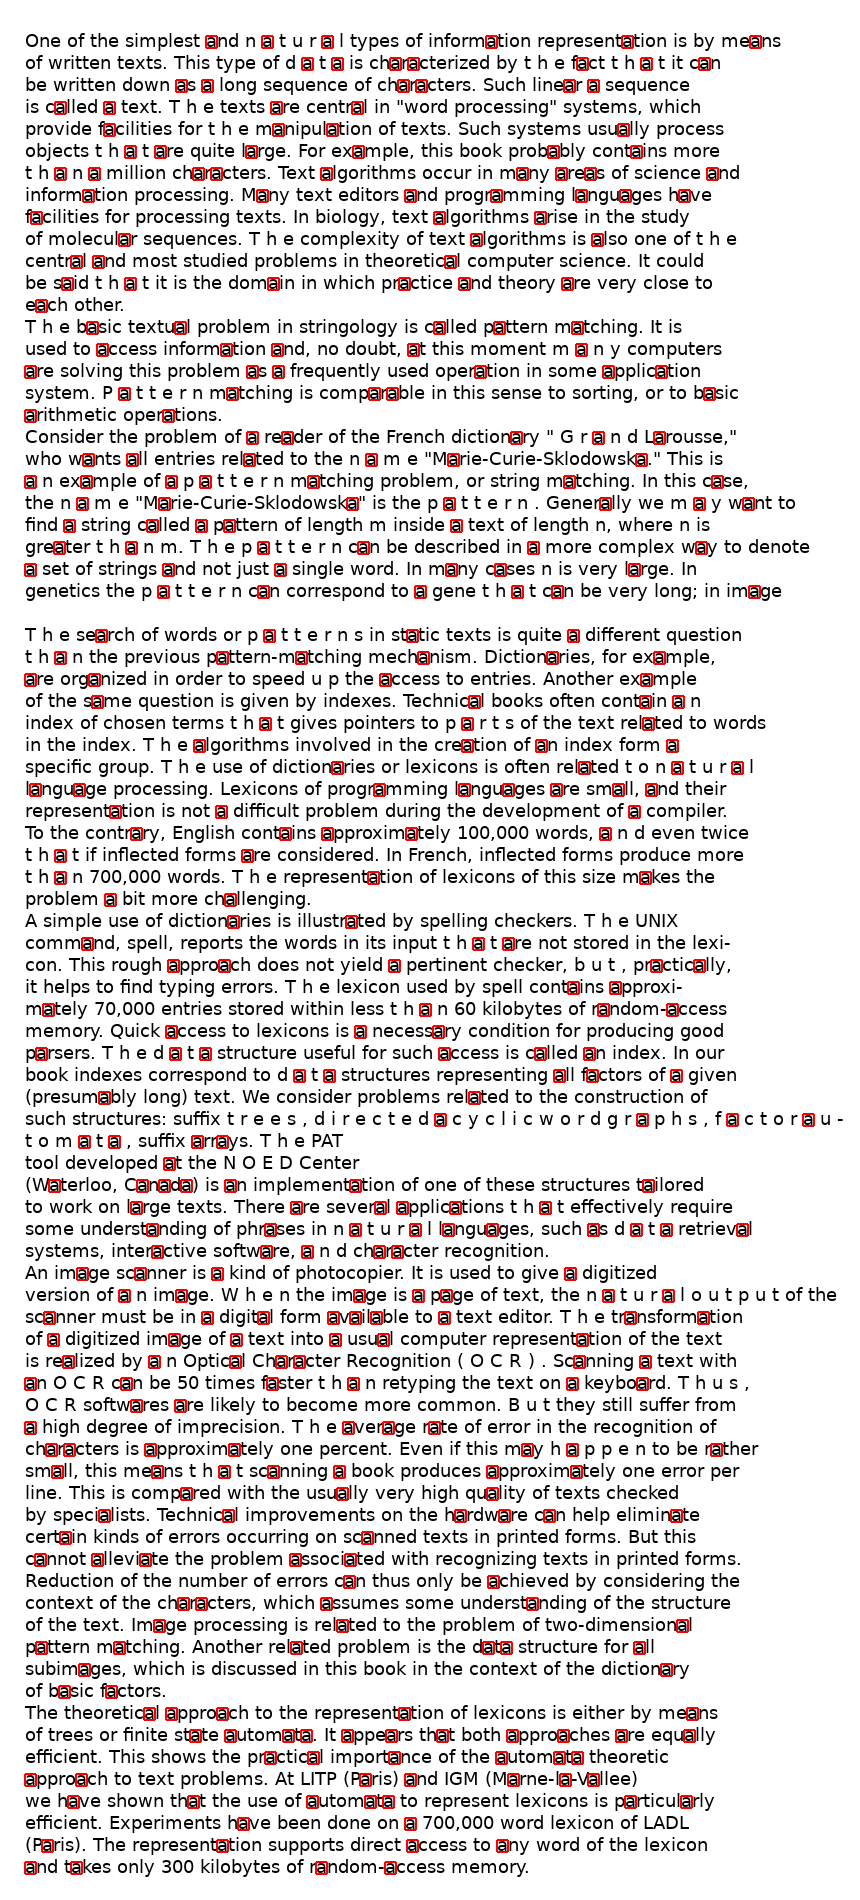

In [120]:
highlight_found(text_image, a_img, a_trie.search(text_array))

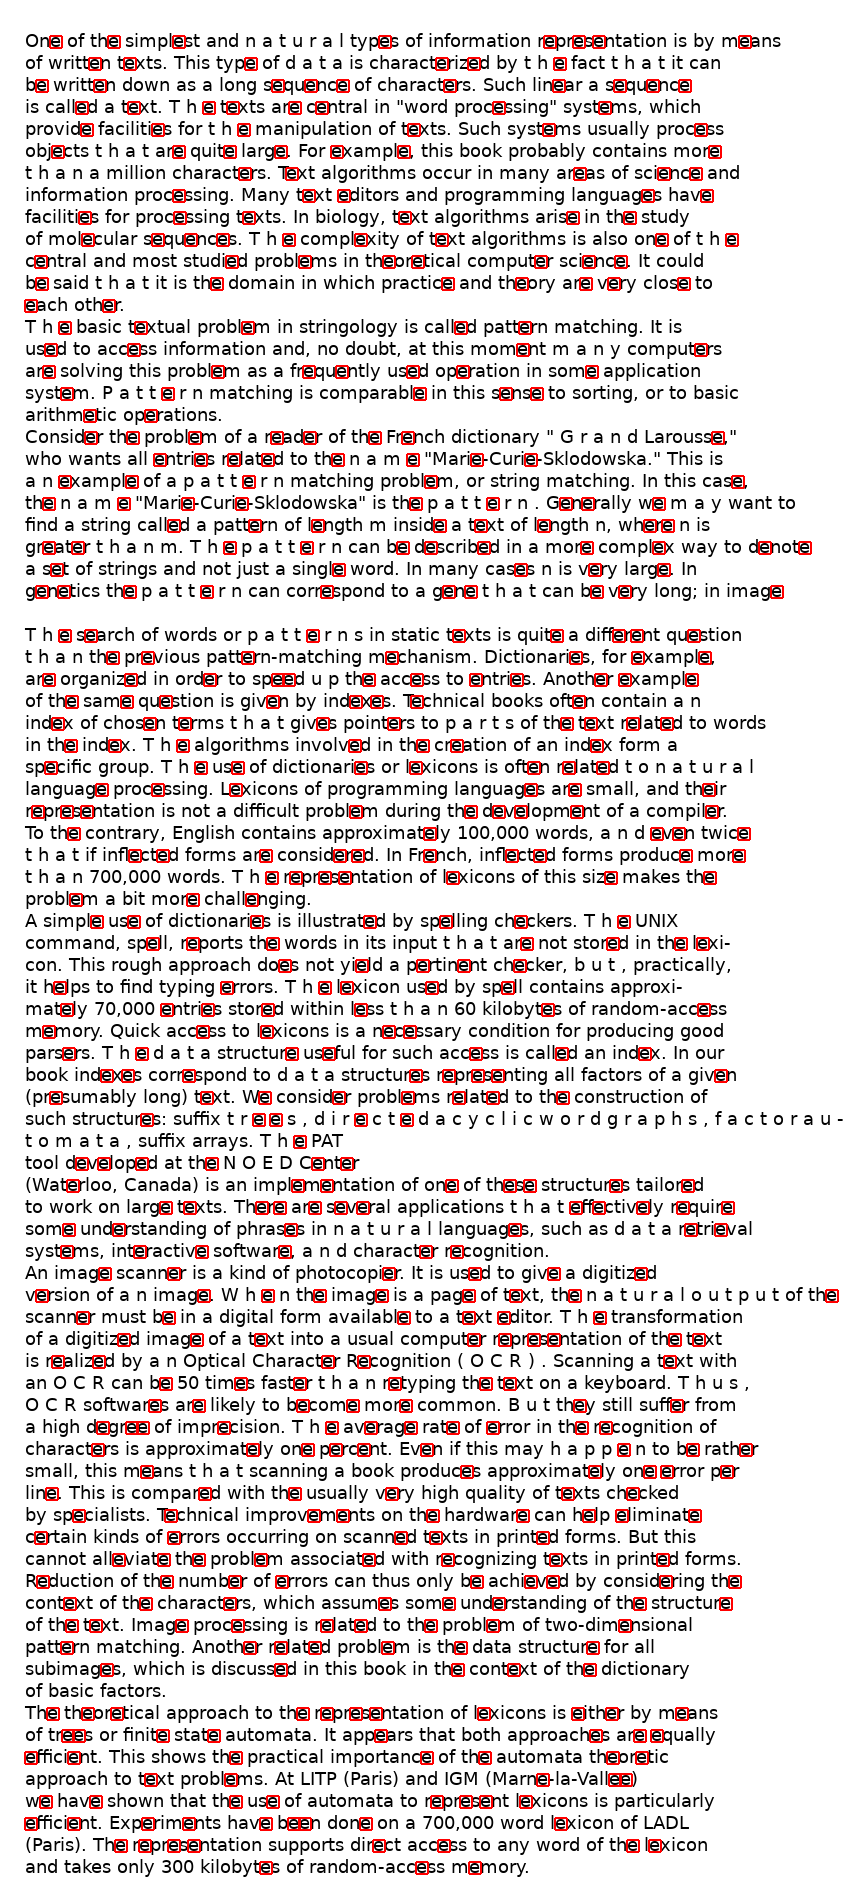

In [121]:
highlight_found(text_image, e_img, e_trie.search(text_array))

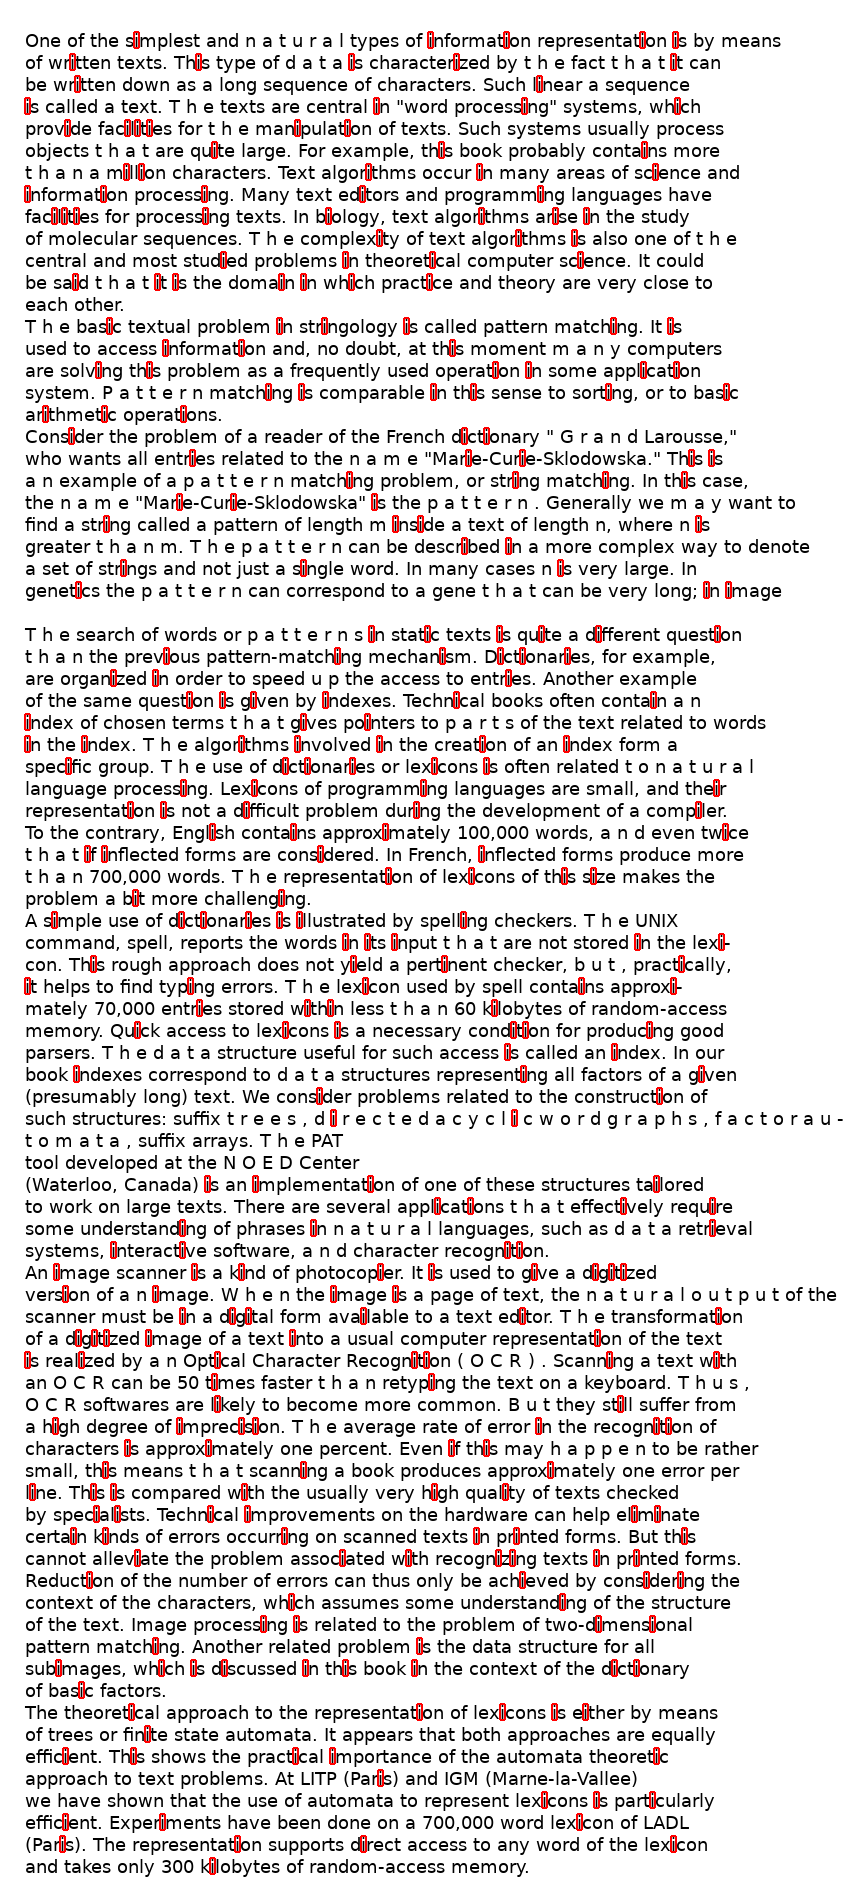

In [122]:
highlight_found(text_image, i_img, i_trie.search(text_array))

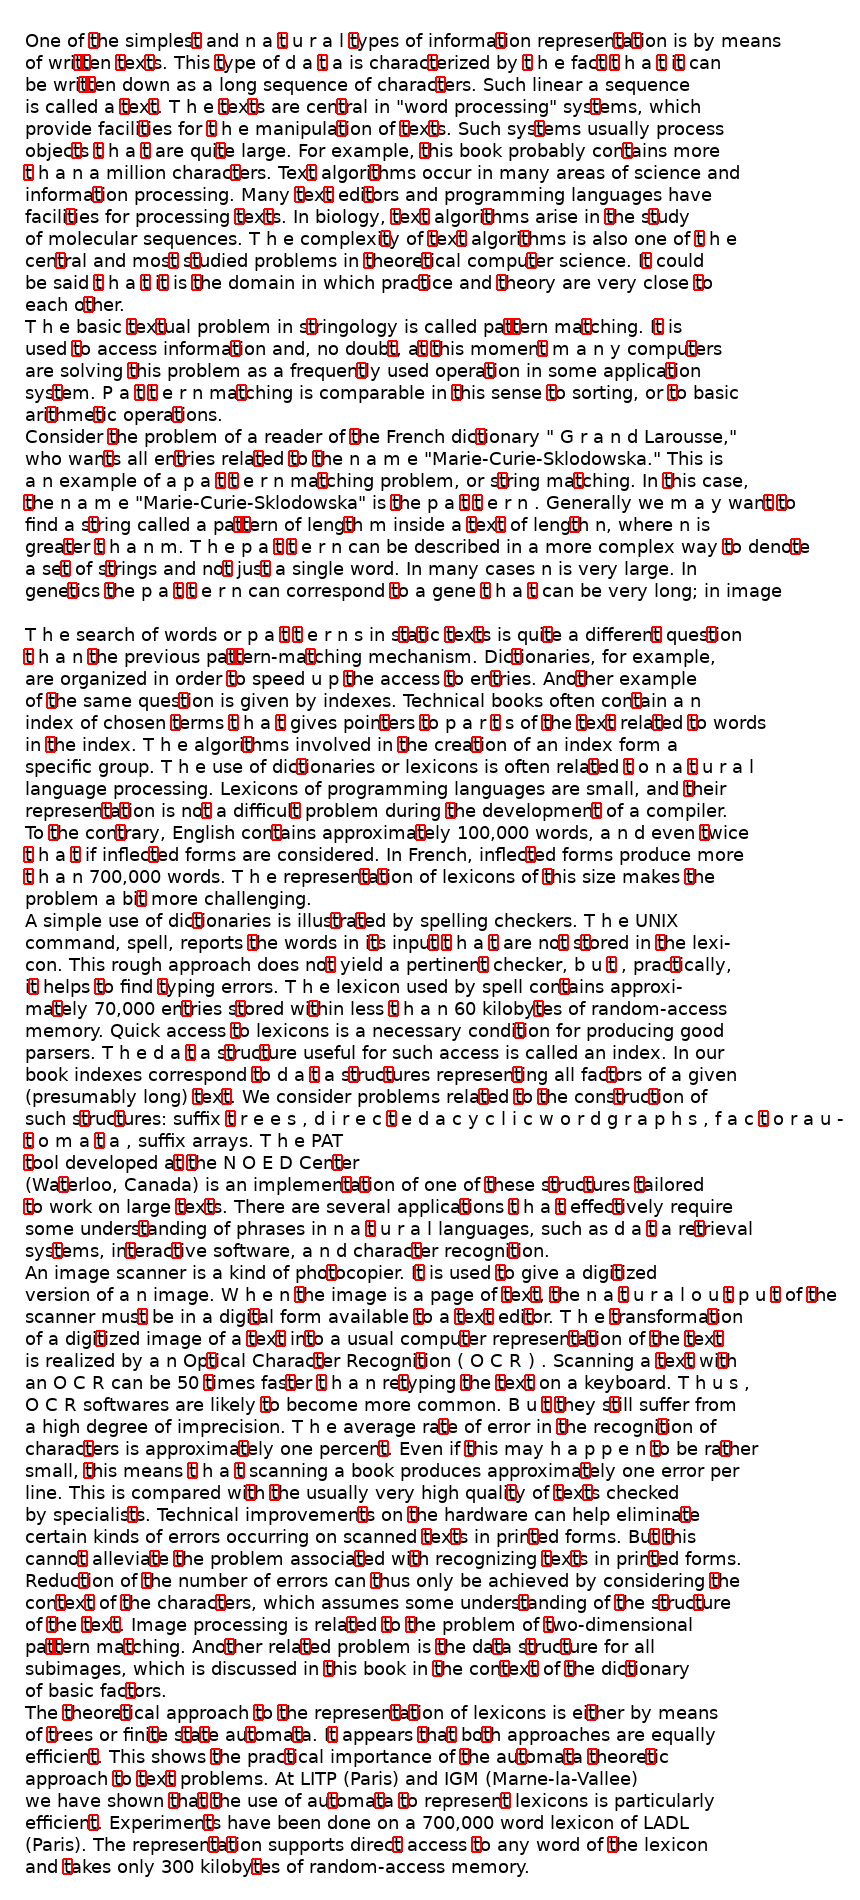

In [123]:
highlight_found(text_image, t_img, t_trie.search(text_array))

## Find 'p a t t e r n' in png image

In [124]:
try:
    pattern_image = Image.open("Resources/pattern.png")
except Exception as e:
    print(e)

In [125]:
pattern_image

In [126]:
pattern_array = convert_image_to_nparray(pattern_image)

trie = AhoCorasickTrie(pattern_array)
occurences = trie.search(text_array)
occurences

[(474, 184), (496, 428), (540, 242), (584, 142), (628, 248)]

In [127]:
naive_matching(pattern_array, text_array)

[(474, 184), (496, 428), (540, 242), (584, 142), (628, 248)]

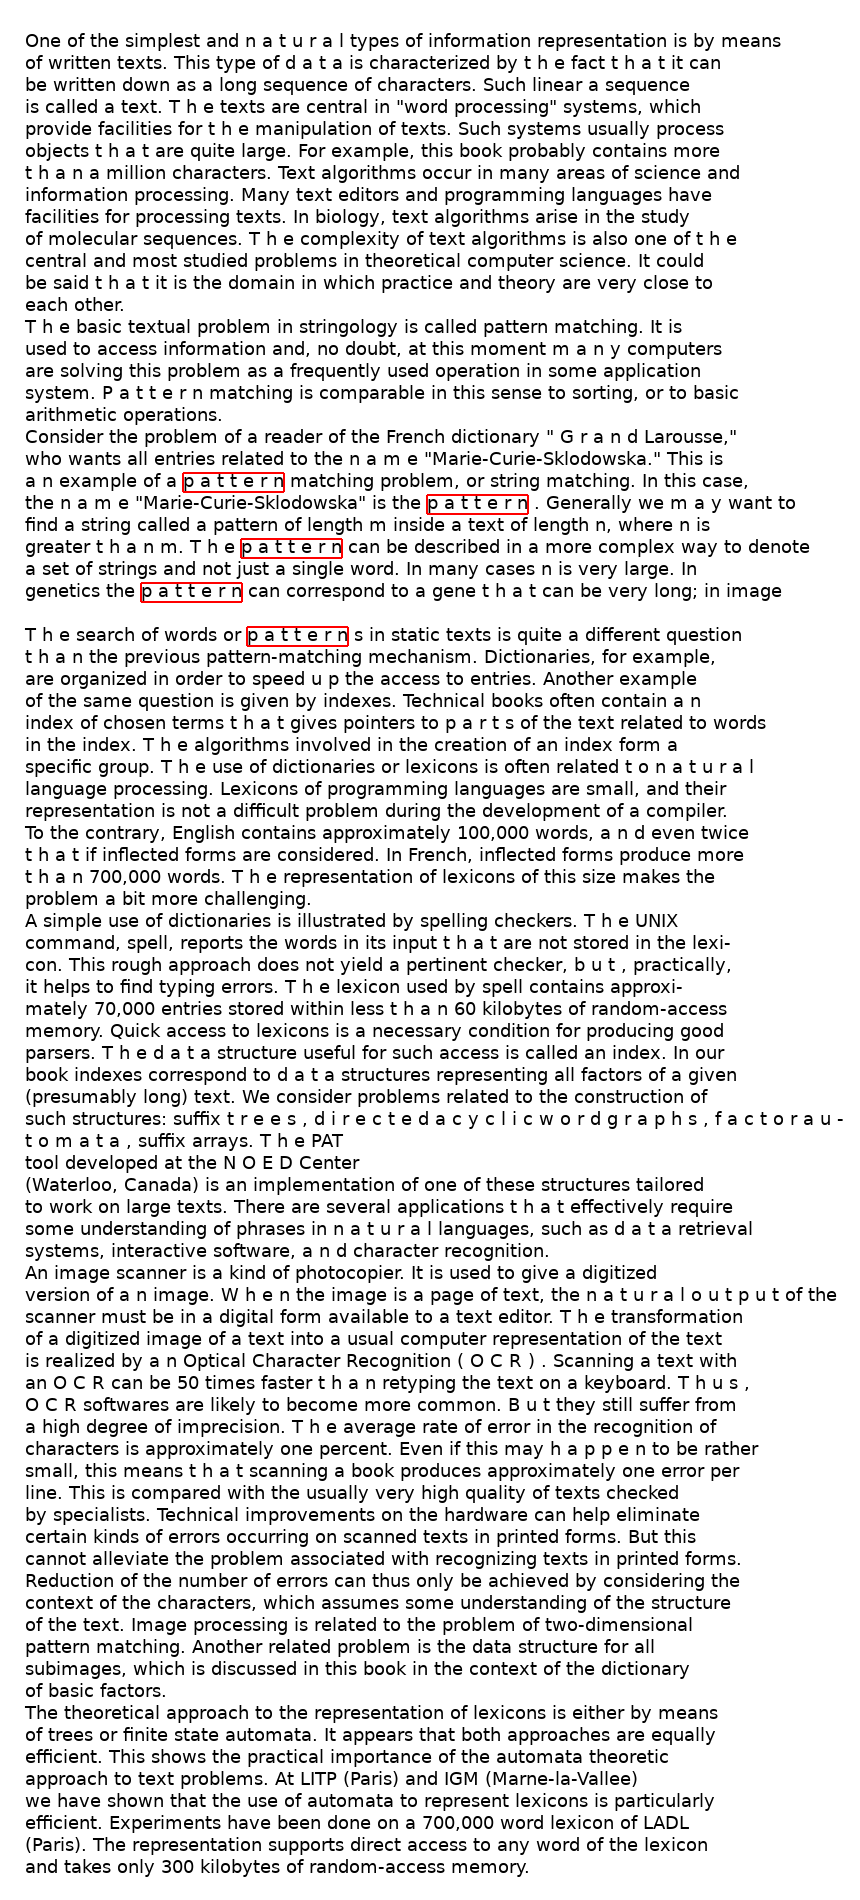

In [128]:
highlight_found(text_image, pattern_image, occurences)

## Time measurements and comparisons

In [108]:
text = np.floor(np.random.random((500, 500)) * 5 + 1)
pat3 = np.floor(np.random.random((3, 4)) * 5 + 1)
pat10 = np.floor(np.random.random((10, 10)) * 5 + 1)
pat70 = np.floor(np.random.random((100, 100)) * 5 + 1)
text[0:100, 321:421] = pat100
text[33:43, 459:469] = pat10
text[215:218, 0:4] = pat3

measure_time(text, [pat3, pat10, pat100])

build_trie_time()                      	      0.093 ms +/- 0.02 ms
search_time()                      	   1098.256 ms +/- 26.13 ms
naive_matching_time()                      	   1010.426 ms +/- 7.06 ms
Results are the same: True
build_trie_time()                      	      0.804 ms +/- 0.13 ms
search_time()                      	   1329.865 ms +/- 37.35 ms
naive_matching_time()                      	    995.492 ms +/- 3.21 ms
Results are the same: True
build_trie_time()                      	     67.216 ms +/- 20.48 ms
search_time()                      	   3165.193 ms +/- 388.18 ms
naive_matching_time()                      	   2020.743 ms +/- 111.84 ms
Results are the same: True


## Divide text into 2, 4 and 8 pieces and perform a pattern search

In [10]:
try:
    pattern_image = Image.open("Resources/pattern.png")
    text_2_1_image = Image.open("Resources/haystack_half_1.png")
    text_2_2_image = Image.open("Resources/haystack_half_2.png")
    text_4_1_image = Image.open("Resources/haystack_quarter_1.png")
    text_4_2_image = Image.open("Resources/haystack_quarter_2.png")
    text_4_3_image = Image.open("Resources/haystack_quarter_3.png")
    text_4_4_image = Image.open("Resources/haystack_quarter_4.png")
    text_8_1_image = Image.open("Resources/haystack_one-eighth_1.png")
    text_8_2_image = Image.open("Resources/haystack_one-eighth_2.png")
    text_8_3_image = Image.open("Resources/haystack_one-eighth_3.png")
    text_8_4_image = Image.open("Resources/haystack_one-eighth_4.png")
    text_8_5_image = Image.open("Resources/haystack_one-eighth_5.png")
    text_8_6_image = Image.open("Resources/haystack_one-eighth_6.png")
    text_8_7_image = Image.open("Resources/haystack_one-eighth_7.png")
    text_8_8_image = Image.open("Resources/haystack_one-eighth_8.png")
except Exception as e:
    print(e)

pattern_array = convert_image_to_nparray(pattern_image)
text_2_1_array = convert_image_to_nparray(text_2_1_image)
text_2_2_array = convert_image_to_nparray(text_2_2_image)
text_4_1_array = convert_image_to_nparray(text_4_1_image)
text_4_2_array = convert_image_to_nparray(text_4_2_image)
text_4_3_array = convert_image_to_nparray(text_4_3_image)
text_4_4_array = convert_image_to_nparray(text_4_4_image)
text_8_1_array = convert_image_to_nparray(text_8_1_image)
text_8_2_array = convert_image_to_nparray(text_8_2_image)
text_8_3_array = convert_image_to_nparray(text_8_3_image)
text_8_4_array = convert_image_to_nparray(text_8_4_image)
text_8_5_array = convert_image_to_nparray(text_8_5_image)
text_8_6_array = convert_image_to_nparray(text_8_6_image)
text_8_7_array = convert_image_to_nparray(text_8_7_image)
text_8_8_array = convert_image_to_nparray(text_8_8_image)

In [14]:
occurences1 = measure_time_multiple_text([text_array], pattern_array)
occurences2 = measure_time_multiple_text([text_2_1_array,
                                          text_2_2_array], pattern_array)
occurences3 = measure_time_multiple_text([text_4_1_array,
                                          text_4_2_array,
                                          text_4_3_array,
                                          text_4_4_array], pattern_array)
occurences4 = measure_time_multiple_text([text_8_1_array,
                                          text_8_2_array,
                                          text_8_3_array,
                                          text_8_4_array,
                                          text_8_5_array,
                                          text_8_6_array,
                                          text_8_7_array,
                                          text_8_8_array], pattern_array)

measure_time_multiple_text()                      	  34555.108 ms +/- 14802.55 ms
measure_time_multiple_text()                      	  54696.336 ms +/- 898.29 ms
measure_time_multiple_text()                      	 116262.002 ms +/- 7957.23 ms
measure_time_multiple_text()                      	 235513.245 ms +/- 17292.91 ms


<b>Measurements above are performed for the following number of parts: 1, 2, 4, 8.</b>

#### Bibliography
* [1] Alfred V. Aho and Margaret J. Corasick. 1975. *Efficient string matching: an aid to bibliographic search.* Commun. ACM 18, 6 (June 1975), 333–340.